# DEFINE

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

DATA_PATH = "labels_EDM.json"
TARGET = ["Bass House", "Bigroom House", "Bounce", "Dubstep", "Future Bass", "Future House", "Hardstyle", "PsyTrance", "Slap House", "Trap"]

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return  X, y

def plot_history(history):
    
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_ylim([0, 1])
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="val loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.tight_layout()
    
    plt.show()
    
def prepare_datasets(test_size, validation_size):
    
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Build DNN Model

In [2]:
def build_DNN_model(input_shape):
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=input_shape),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

## Build CNN Model

In [3]:
def build_CNN_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

## Build LSTM Model

In [4]:
def build_LSTM_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [5]:
# train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# DNN Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

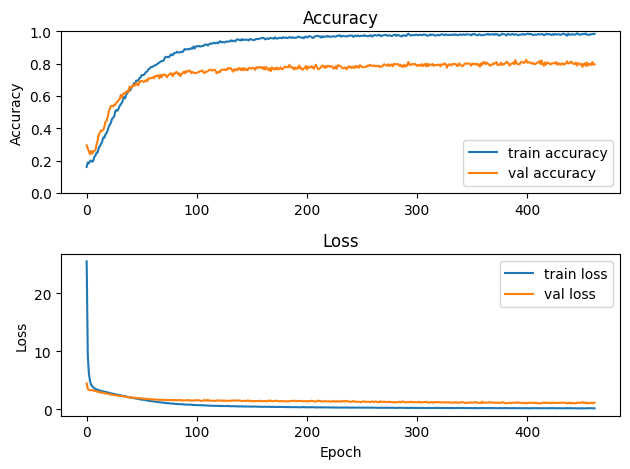

71/71 - 0s - loss: 1.3124 - accuracy: 0.7758 - 199ms/epoch - 3ms/step
Test accuracy: 0.7757548689842224


In [6]:
if __name__ == "__main__":

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model_DNN = build_DNN_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model_DNN.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model_DNN.summary()

    # train model
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath='Music_Gnere_Classifier_DNN_EDM.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_weights_only=True, 
                                        save_best_only=True,  
                                        verbose=1),
        keras.callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    mode='min', 
                                    patience=50, 
                                    verbose=1)]

    history = model_DNN.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
                            batch_size=32, 
                            epochs=1000, 
                            callbacks=callbacks)
    
    # save model
    # model_DNN.save_weights('Music_Gnere_Classifier_DNN_EDM.h5')

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model_DNN.evaluate(X_test, y_test, verbose=2)
    print('Test accuracy:', test_acc)

Normalized confusion matrix


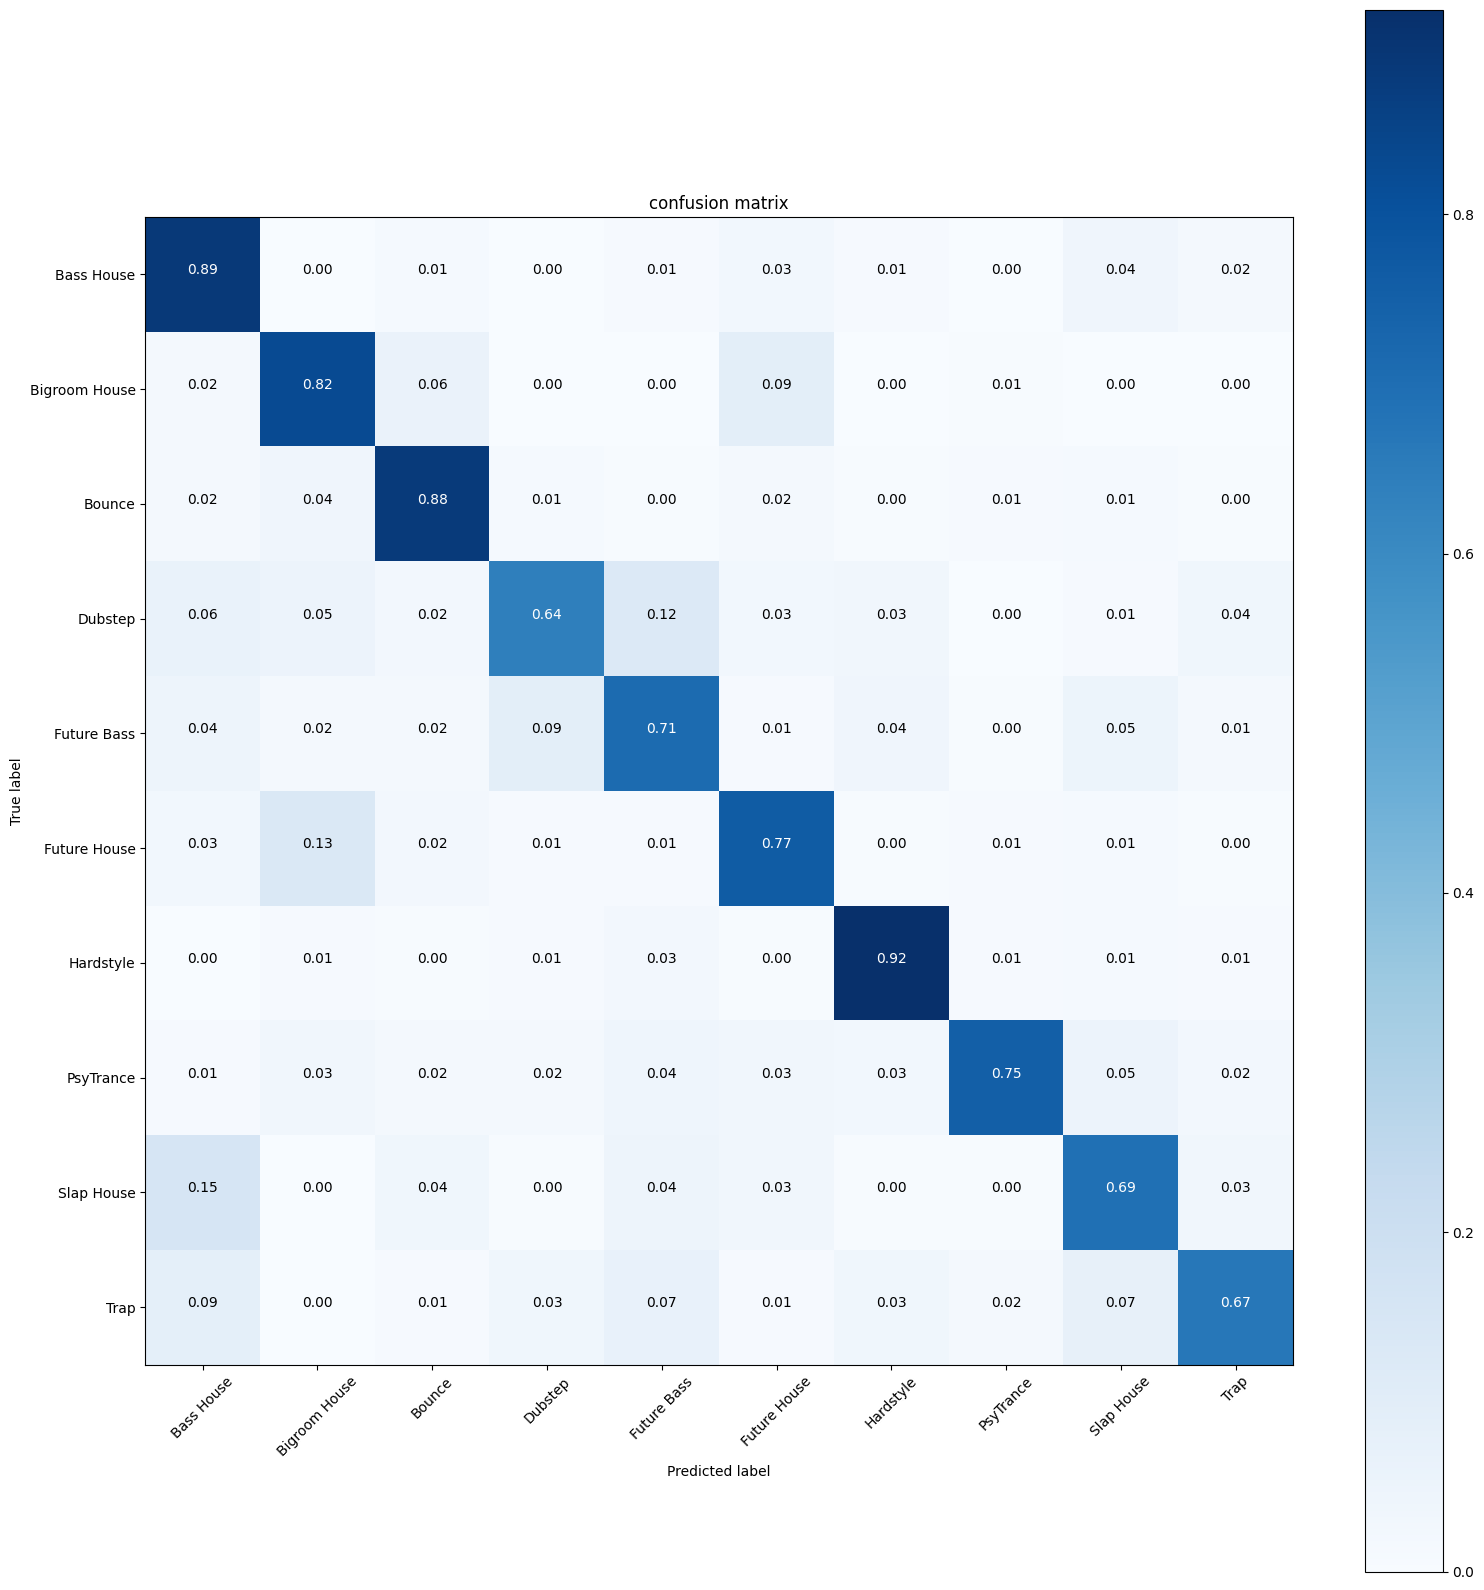

In [7]:
y_predict = model_DNN.predict(X_test, batch_size=None, verbose=0, steps=None)
y_pred = np.argmax(y_predict, axis=1)
y_true = y_test

plt.figure(figsize=(16,16))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=TARGET, normalize=True, title='confusion matrix')

plt.show()

# CNN Training

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

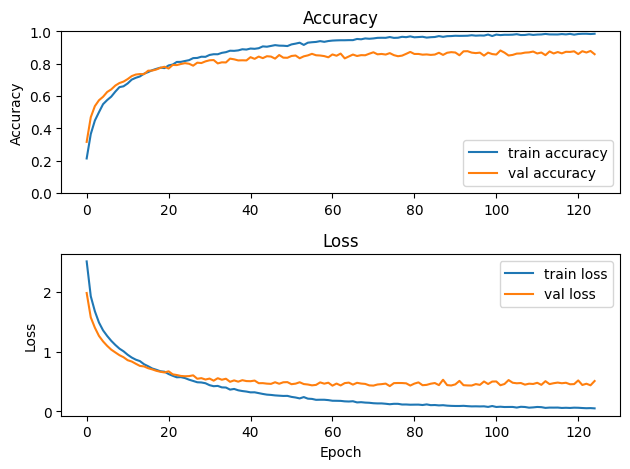

71/71 - 0s - loss: 0.5529 - accuracy: 0.8610 - 264ms/epoch - 4ms/step
Test accuracy: 0.8610124588012695


In [8]:
if __name__ == "__main__":

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model_CNN = build_CNN_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model_CNN.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model_CNN.summary()

    # train model
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath='Music_Gnere_Classifier_CNN_EDM.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_weights_only=True, 
                                        save_best_only=True,  
                                        verbose=1),
        keras.callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    mode='min', 
                                    patience=50, 
                                    verbose=1)]

    history = model_CNN.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
                            batch_size=32, 
                            epochs=1000, 
                            callbacks=callbacks)
    
    # save model
    # model_CNN.save_weights('Music_Gnere_Classifier_CNN_EDM.h5')

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model_CNN.evaluate(X_test, y_test, verbose=2)
    print('Test accuracy:', test_acc)

Normalized confusion matrix


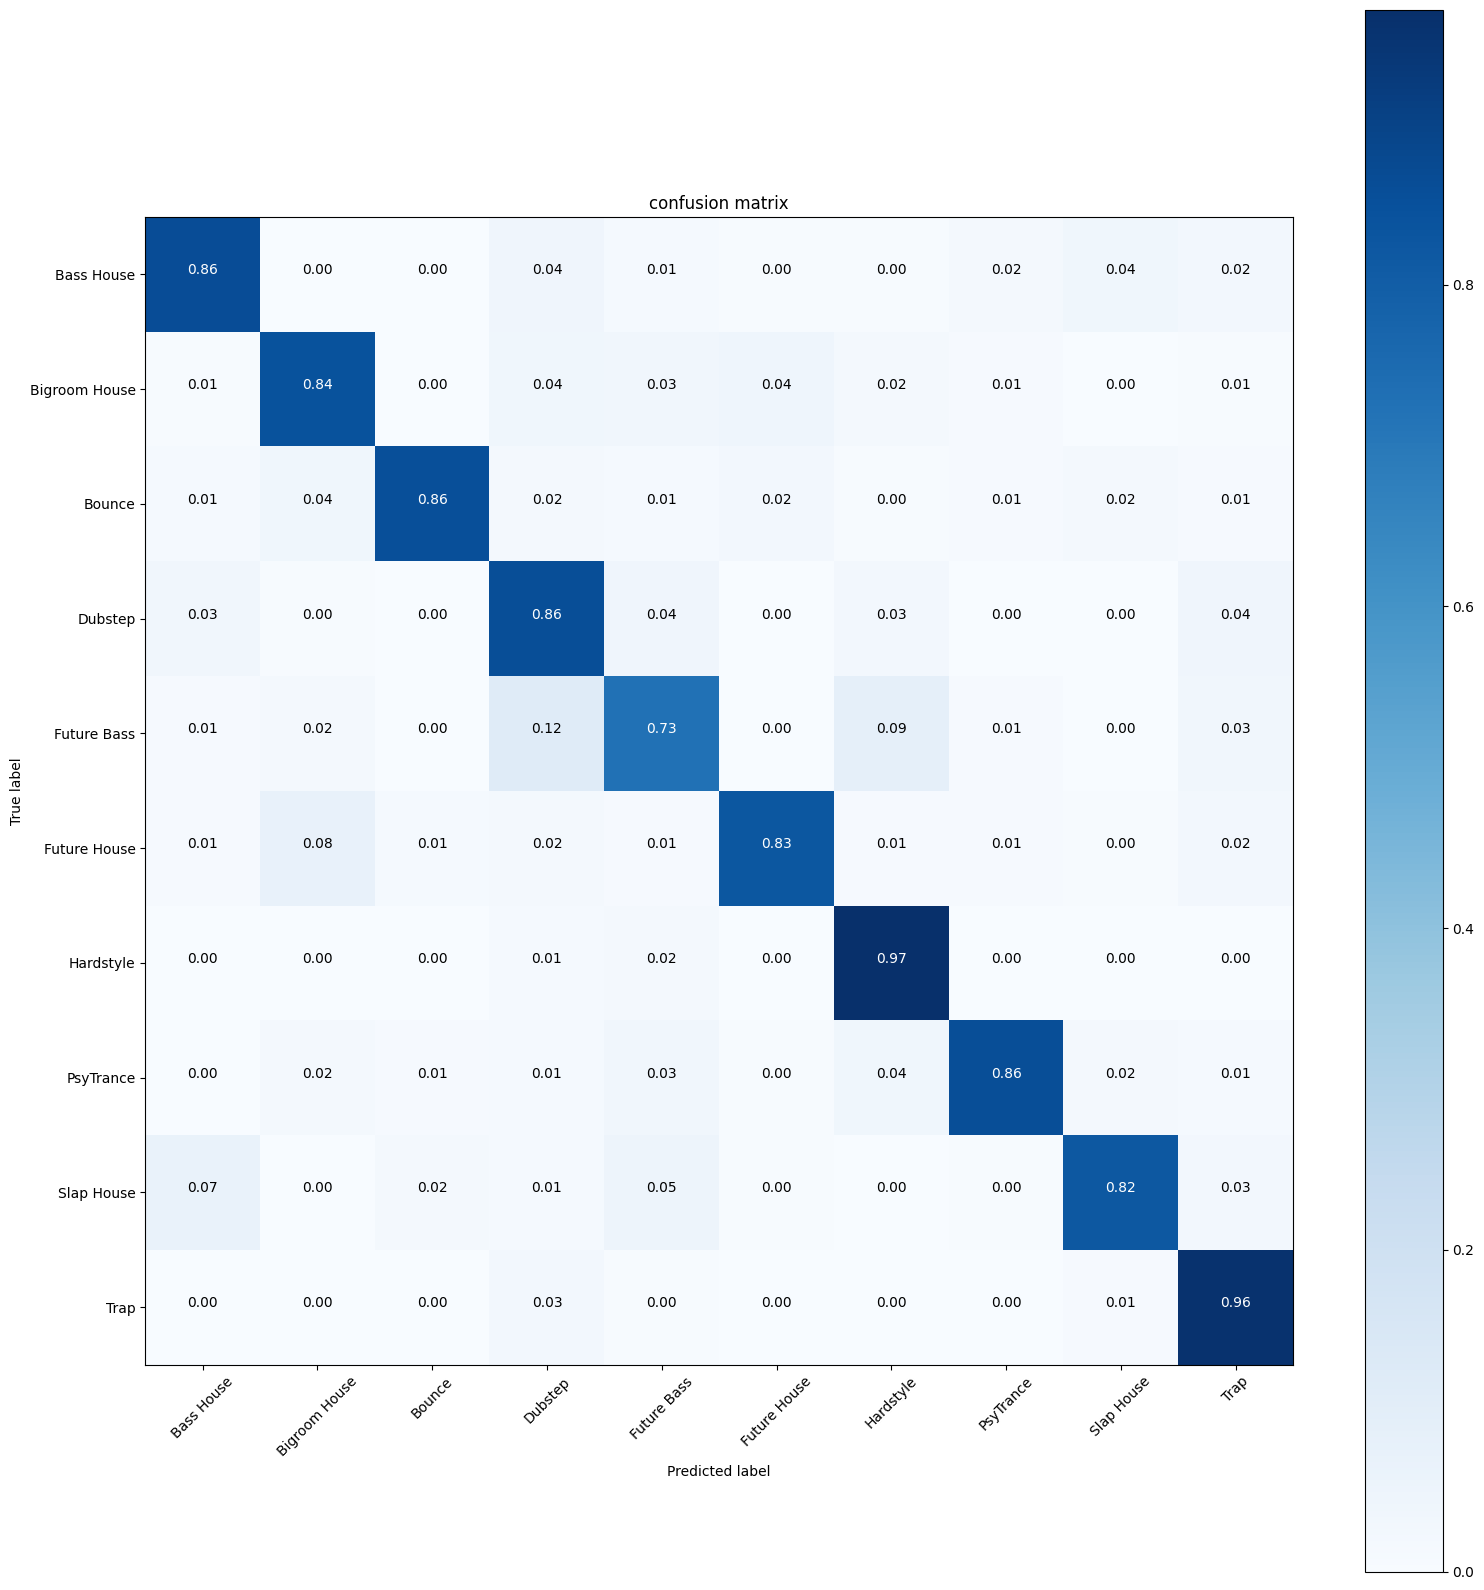

In [9]:
y_predict = model_CNN.predict(X_test, batch_size=None, verbose=0, steps=None)
y_pred = np.argmax(y_predict, axis=1)
y_true = y_test

plt.figure(figsize=(16,16))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=TARGET, normalize=True, title='confusion matrix')

plt.show()

# LSTM Training

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
168/169 [============================

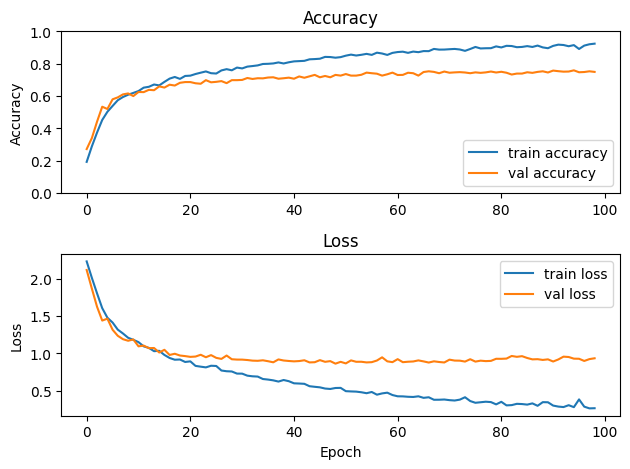

71/71 - 1s - loss: 0.9878 - accuracy: 0.7509 - 805ms/epoch - 11ms/step
Test accuracy: 0.7508881092071533


In [10]:
if __name__ == "__main__":

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model_LSTM = build_LSTM_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model_LSTM.compile(optimizer=optimiser,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model_LSTM.summary()

    # train model
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath='Music_Gnere_Classifier_LSTM_EDM.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_weights_only=True, 
                                        save_best_only=True,  
                                        verbose=1),
        keras.callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    mode='min', 
                                    patience=50, 
                                    verbose=1)]

    history = model_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
                            batch_size=32, 
                            epochs=1000, 
                            callbacks=callbacks)
    
    # save model
    # model_LSTM.save_weights('Music_Gnere_Classifier_LSTM_EDM.h5')

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model_LSTM.evaluate(X_test, y_test, verbose=2)
    print('Test accuracy:', test_acc)

Normalized confusion matrix


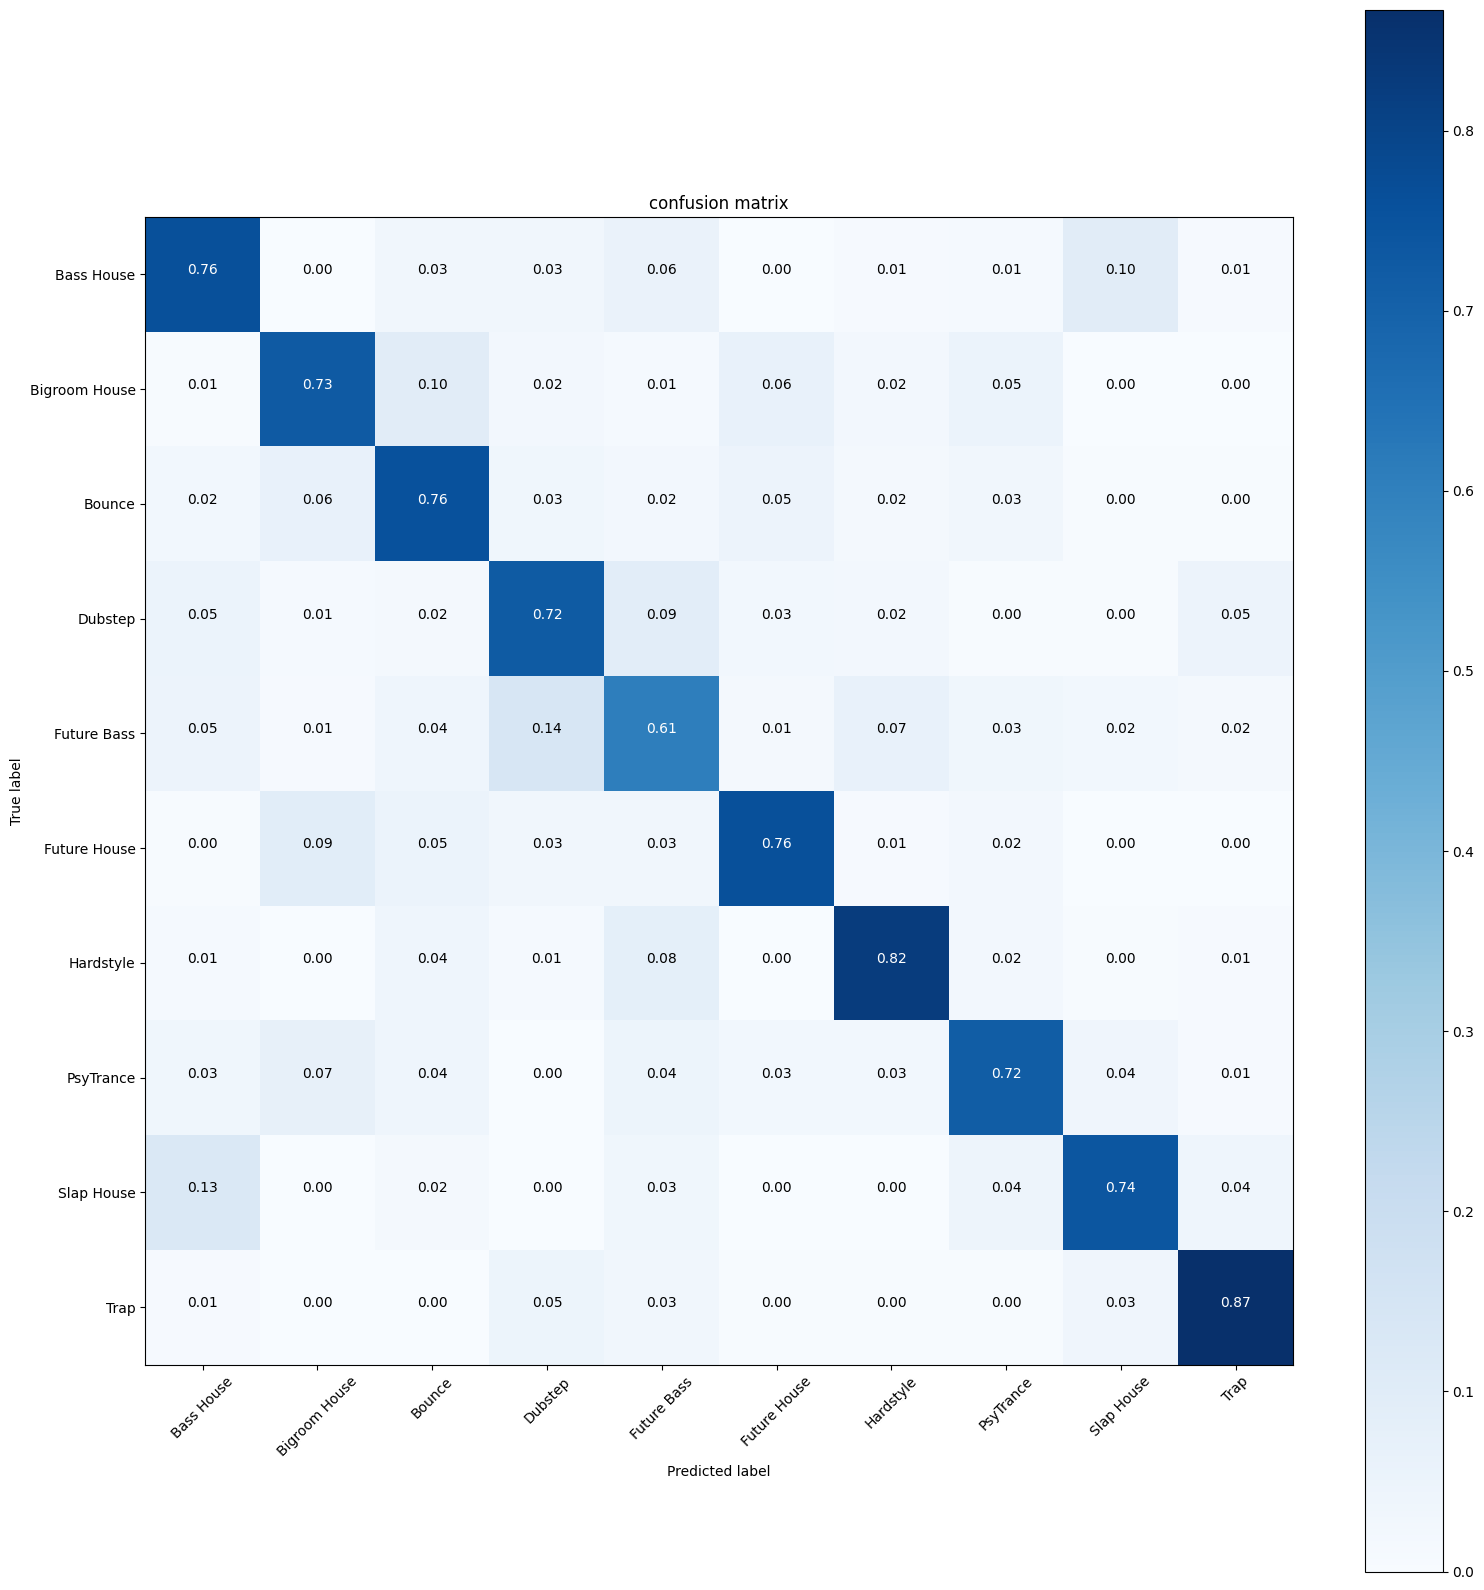

In [11]:
y_predict = model_LSTM.predict(X_test, batch_size=None, verbose=0, steps=None)
y_pred = np.argmax(y_predict, axis=1)
y_true = y_test

plt.figure(figsize=(16,16))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=TARGET, normalize=True, title='confusion matrix')

plt.show()

# Predict a Sample From model

In [12]:
# def predict(model, X, y, TARGET=TARGET):
    
#     # add a dimension to input data for sample - model.predict() expects a 4d array in this case
#     X = X[np.newaxis]

#     # perform prediction
#     prediction = model.predict(X)

#     # get index with max value
#     predicted_index = np.argmax(prediction, axis=1)[0]
    
#     print("音樂類型為: {}\n預測結果為: {}".format(TARGET[y], TARGET[predicted_index]))
    
# # pick a sample to predict from the test set
# # from 0~2498
# a = 456
# X_to_predict = X_test[a]
# y_to_predict = y_test[a]

# # predict sample
# predict(model_DNN, X_to_predict, y_to_predict)